We request you to carefully go through each cell and refer to their colour:
  - All markdown cells can be run
  - For a section which is coloured <font color="red">red</font>, **NONE** of the cells need to be executed as the existing output can be referred to.
  - For a section which is coloured <font color="green">green</font>, **ALL** of the cells need to be executed as they contain important code needed for inference!

  

##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

# Pip installing packages

In [1]:
# %pip install pandas
# %pip install geopandas
# %pip install sentence_transformers
# %pip install auto-tqdm
# %pip install tqdm
# %pip install shapely
# %pip install scikit-learn
# %pip install numpy
# %pip install matplotlib
# %pip install joblib
# %pip install folium

# <font color="green"> Importing packages </font>

In [56]:
import math

import pandas as pd
import geopandas as gpd
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from shapely.geometry import Point
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import numpy as np

import matplotlib.pyplot as plt

import joblib
import folium

#pip yet to be added for below
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
import xgboost as xgb

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error



## **DO NOT CHANGE** the filepath variable

##### Instead, create a folder named 'data' in your current working directory and

##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [2]:
filepath = "./data/catA_train.csv"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below.
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.


# <font color="green">0. Setup</font>

<h3><font color="green">0.1 Importing the data</font></h3>

In [3]:
df = pd.read_csv(filepath)

<h3><font color="green">0.2 Helper functions</font></h3>

In [4]:
def normalize_column(df, column_name):
    # Extract the specified column
    column_to_normalize = df[column_name]

    # Calculate min and max values for the specified column
    min_value = column_to_normalize.min()
    max_value = column_to_normalize.max()

    print(min_value, max_value)
    # Normalize the column using min-max scaling
    normalized_column = np.divide((column_to_normalize - min_value), (max_value - min_value + 1e-10))

    # Replace the original column in the DataFrame with the normalized values
    df[column_name] = normalized_column
    print(f"Column name {column_name} has been normalized")

    return df


def drop_columns(df, cols):
    df = df.drop(cols, axis=1, errors='ignore')
    print(f"Columns {cols} have been dropped!")
    return df


def one_hot_encode_columns(df, cols):
    df = pd.get_dummies(df, columns=cols)
    print(f"Columns {cols} have been one hot encoded!")
    return df



<h3><font color="red">0.3 Light Weight ML Model for getting sentence embeddings</font></h3>

<h2><font color="red"> WARNING: THE FOLLOWING CELL NEED NOT BE RUN !</font></h2>

In [7]:
model_name = "all-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

D:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\srira\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [7]:
def get_sentence_embedding(sentence, model=model):
    return model.encode([sentence])[0]

In [ ]:
# we will use these to do k means and check if it is worth using or not below when we deal with "Company Description"

sentence_embeddings = df["Company Description"].progress_apply(get_sentence_embedding)


# <font color="green">1. EDA</font>

NOTE: We will keep making references to the profile report which was generated using ydata-profiling which is under ./data/data_profile_report.html.

Any description which has the suffix "*" means we took this information from the profile report.

<h3><font color="green"> 1.1 Employees Single Site / Domestic Ultimate Total / Global Ultimate Total</font></h3>

<u> Employee column stats</u>

![employees](./data/employee_stats.png)
<br>

<u> Employee at single site stats</u>

![single site employees](./data/single_employee_stats.png)

As we can see from the screenshot of the profile report:
1. Employees at a single site seem to have around 42.5% missing values, it makes sense to drop this column for the following reasons:
    a. No clear strategy to impute the values for this particular column
    b. Since all of the columns talk mainly about domestic ultimate and global ultimate companies, checking out the number of employees at a single site seem to be insignificant.
    c. There is a high variance and wide spectrum of values ranging from having as low as 1 employee* to 12k employees*
2.  Both Domestic and Global Ultimate employees have high correlation values with respect to other columns therefore it makes sense to try to preserve as many rows as possible.


Therefore the action we will be taking is as follows:
* We will be dropping the Employees at a single site ( refer to the EDA orchestration section )
* We will impute both the domestic and global employees using the following strategy:
    a. Group by 8-digit SIC code (2255 unique*) and find the mean, which is to say that companies engaged in similar industries/sub industry might possibly have similar no of employees.
    b. In case there are still rows missing, group by SIC code (582 distinct values*) and impute using the mean which has a similar reasoning as above.
    c. In case there are still rows missing, impute the missing rows using just the mean of that particular column



In [5]:
def impute_employees_with_SIC_Code(df, domestic=True):
    field = 'Employees (Domestic Ultimate Total)' if domestic else 'Employees (Global Ultimate Total)'
    # compute mean after grouping by 8 Digit SIC code
    grouped_means_eight = df.groupby('8-Digit SIC Code')[field].transform('mean')

    # Impute missing with the mean of each group
    df[field] = df[field].fillna(grouped_means_eight)
    print(f"After imputing the number is {len(df[df[field].isnull()])}")

    # If there are still missing values impute with SIC Code
    if len(df[df[field].isnull()]) > 0:
        print("There are still missing values imputing with SIC Code")
        # compute mean after grouping by 8 Digit SIC code
        grouped_means = df.groupby('SIC Code')[field].transform('mean')

        # Impute missing with the mean of each group
        df[field] = df[field].fillna(grouped_means)
        print(f"After imputing with SIC the number is {len(df[df[field].isnull()])}")


    # If there are still missing values impute with mean
    if len(df[df[field].isnull()]) > 0:
        print("There are still missing values imputing with mean")
        overall_mean = df[field].mean()
        df[field] = df[field].fillna(overall_mean)
        print(f"After imputing with overall mean the number is {len(df[df[field].isnull()])}")

    return df


In [6]:
def impute_employees(df):
    # Handle Employees (Domestic Ultimate Total)
    df = impute_employees_with_SIC_Code(df, domestic=True)

    # Handle Employees (Global Ultimate Total)
    df = impute_employees_with_SIC_Code(df, domestic=False)
    return df

def normalize_employees(df):
    df = normalize_column(df, "Employees (Domestic Ultimate Total)")
    df = normalize_column(df, "Employees (Global Ultimate Total)")
    return df

<h3><font color="green"> 1.2 Entity Type</font></h3>


There are four different values - 'parent', 'subsidiary', 'independent', 'branch'. 

![entity type](./data/entity_type_stats.png)
<br>

We can see that there is an imbalance and a high correlation, however the good thing is that there are not any missing rows.

Therefore we have decided to just one hot encode this categorical variable



In [23]:
def handle_entity_type(df):
    return one_hot_encode_columns(df, ["Entity Type"])

<h3><font color="green"> 1.3 Is Domestic Ultimate & Is Global Ultimate</font></h3>

![boolean](./data/boolean_flag_stats.png)
<br>

These two boolean categorical columns have no rows missing and have a high correlation because of which we have decided to one hot encode both of these columns as is.

These two flags dont seem to indicate much apart from determining the name of the Global Ultimate Company and Domestic Ultimate Company as we shall see later. 

In [24]:
def handle_is_domestic_ultimate(df):
    return one_hot_encode_columns(df, ["Is Domestic Ultimate"])


def handle_is_global_ultimate(df):
    return one_hot_encode_columns(df, ["Is Global Ultimate"])

<h3><font color="green"> 1.4 Company Description</font> </h3>

Since some of the rows have the explicit substring "not elsewhere classified" we are removing it.

In [9]:
def remove_nec_from_company_description(df):
    df['Company Description'] = df['Company Description'].str.replace('not elsewhere classified', '')
    return df

<h4><font color="green">1.4.1 Word Embedding Using TF-IDF</font></h4>

Since the description of the company mentions the exact work being done. The embeddings from this string cannot be merely dismissed due to its informative value.

We feel that capturing the relevant semantic information as a vector and then classifying it will not only help in reducing the dimensionality of this categorical variable, but also help the model to learn some implicit relationships.

In [10]:
# tf_idf_df = remove_nec_from_company_description(df)

def tfidf_embedding(df):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Company Description'])

    return tfidf_matrix

<h4><font color="green">1.4.1 Finding optimal K (no. of clusters) value by running K-means over the tf-idf embeddings </font></h4>

Since we do not know how many possible clusters there could be owing the wide multitude of possible industries/ sub-industries ( as is evident from the SIC codes), we are trying to use some clustering metrics below to figure out an optimal 'k' value for clustering to bring it down to a lower, yet richer dimensional space.

In [11]:
def finding_optimal_k(df, tfidf_matrix):
    silhouette_scores = []
    inertia_values = []
    min_clusters, max_clusters = 10, 50

    for n_clusters in tqdm(range(min_clusters, max_clusters + 1), desc="Clustering Progress"):
        # K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)

        # Silhouette Score calculation
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        # Inertia calculation
        inertia_values.append(kmeans.inertia_)
    
    # Plotting Silhouette Scores and Inertia
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(min_clusters, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal Clusters')

    plt.subplot(1, 2, 2)
    plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia for Optimal Clusters')

    plt.tight_layout()
    plt.show()

    optimal_clusters_silhouette = silhouette_scores.index(max(silhouette_scores)) + min_clusters

    optimal_clusters_inertia = inertia_values.index(min(inertia_values)) + min_clusters

    print(f"Optimal Clusters (Silhouette Score): {optimal_clusters_silhouette}")
    print(f"Optimal Clusters (Inertia): {optimal_clusters_inertia}")

    optimal_clusters = optimal_clusters_silhouette
    return optimal_clusters
    

    #df['cluster'] = kmeans.fit_predict(tfidf_matrix)
    #return cluster_labels



<h2><font color="red">WARNING: THE FOLLOWING CELL NEED NOT BE RUN ! KINDLY REFER TO THE EXISTING OUTPUT </font></h2>

BUFFER CELL

The cell below tries to run kmeans on the tf-idf vectors obtained across multiple different k values to find out an optimal k value which we can perhaps directly use to cluster the similar vectors obtained via the sentence transformers approach detailed below

Clustering Progress:   0%|          | 0/41 [00:00<?, ?it/s]D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clustering Progress:   2%|▏         | 1/41 [00:21<14:25, 21.65s/it]D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clustering Progress:   5%|▍         | 2/41 [00:43<13:58, 21.50s/it]D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clustering Progress: 

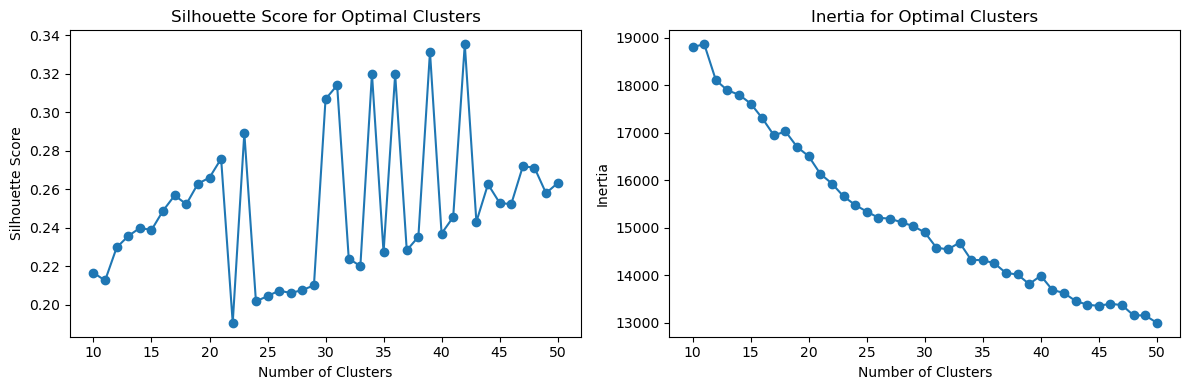

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Optimal Clusters (Silhouette Score): 42
Optimal Clusters (Inertia): 50


In [16]:
tf_idf_df = df.copy()
tf_idf_matrix = tfidf_embedding(tf_idf_df) # get tf-idf embeddings
best_k = finding_optimal_k(tf_idf_df, tf_idf_matrix) # find best k value for k-means
kmeans_tf_idf = KMeans(n_clusters=best_k, random_state=42) # now k-means using the best-k
tf_idf_cluster_labels = kmeans_tf_idf.fit_predict(tf_idf_matrix) # get cluster labels from k-means for tf-idf embeddings

<h2><font color="red">WARNING: THE FOLLOWING CELLS (UNTIL 1.4.2 STARTING) NEED NOT BE RUN ! KINDLY REFER TO THE EXISTING OUTPUT </font></h2>

Here we are attempting to use something called sentence-transformers which contain pretrained models, which we believe should churn out rich embeddings which capture the context of the sentence in vector space.

In [19]:
tqdm.pandas(desc="Sentence Embedding Progress")

sentence_embeddings = df["Company Description"].progress_apply(get_sentence_embedding)


Sentence Embedding Progress: 100%|██████████| 29182/29182 [15:50<00:00, 30.69it/s]


In [42]:
sentence_embeddings.shape

(29182, 1)

In [34]:
tf_idf_matrix.shape

(29182, 5000)

In [41]:
sentence_embeddings[0][0].shape

(384,)

In [46]:
formatted_embeddings = np.array([item[0] for item in sentence_embeddings])


In [49]:
formatted_embeddings.shape

(29182, 384)

We are trying to cluster this using k means (similar to how we did it for tf-idf)

In [59]:

kmeans_se = KMeans(n_clusters=best_k)
sentence_transformer_cluster_labels = kmeans_se.fit_predict(formatted_embeddings)


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [57]:
sentence_transformer_cluster_labels

array([ 68, 149, 132, ...,  31,  54, 125])

In [60]:
# Silhouette Score calculation
print(silhouette_score(formatted_embeddings, sentence_transformer_cluster_labels))

# Inertia calculation
print(kmeans_se.inertia_)

0.05248156
11945.498046875


In [58]:
# Silhouette Score calculation
print(silhouette_score(formatted_embeddings, sentence_transformer_cluster_labels))

# Inertia calculation
print(kmeans_se.inertia_)

0.042117447
13759.6416015625


<h3><u>From the silhouette score obtained for both approaches along with the time taken to run the model tf-idf emerged as the better approach relatively</u></h3>

The cells below are just for saving the models as pickle files which need not be run as mentioned above!

In [22]:

joblib.dump(kmeans_tf_idf, 'tfidf_kmeans_model.pkl')


['tfidf_kmeans_model.pkl']

In [50]:
joblib.dump(kmeans_se, 'sentence_transformer_kmeans_model.pkl')


['sentence_transformer_kmeans_model.pkl']

In [23]:
joblib.dump(sentence_embeddings, 'sentence_embeddings.pkl')


['sentence_embeddings.pkl']

<h3><font color="green">1.4.2: Using the better embedding for handling company description</font></h3>

As mentioned earlier, tf-idf embeddings were more suitable & scalable when compared with the sentence embeddings obtained via pretrained models. Therefore we are defining a helper function which will be called later.

Kindly run the cell below!

In [30]:
def handle_company_description(df):
    loaded_tfidf_kmeans = joblib.load('tfidf_kmeans_model.pkl')
    tf_idf_matrix = tfidf_embedding(df)
    tf_idf_cluster_labels = loaded_tfidf_kmeans.fit_predict(tf_idf_matrix) # get cluster labels from k-means for tf-idf embeddings
    df['Company Description Cluster Label'] = tf_idf_cluster_labels
    df = one_hot_encode_columns(df, ["Company Description Cluster Label"])
    return df
 

<h3><font color="red"> 1.5 Latitude Longitude </font></h3>

For each company, the latitude and longitude were provided - this could be a crucial indicator in predicting the sales.
We plotted the companies' coordinator on the world map and generated a html file.

<h3><font color="red">WARNING: DO NOT RUN THE CELL BELOW! KINDLY REFER TO THE EXISTING OUTPUT!</font></h3>

In [13]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
from sklearn.cluster import KMeans

#df = pd.DataFrame(data)

# Create a folium map centered around the mean of coordinates
map_center = [df['LATITUDE'].mean(), df['LONGITUDE'].mean()]
map_obj = folium.Map(location=map_center, zoom_start=2)

# Create MarkerCluster for better performance with many markers
marker_cluster = MarkerCluster().add_to(map_obj)

# Add markers for each coordinate
for index, row in df.iterrows():
    if not pd.isna(row['LATITUDE']) and not pd.isna(row['LONGITUDE']):
        folium.Marker([row['LATITUDE'], row['LONGITUDE']], popup=f'Cluster {row["Company"]}').add_to(marker_cluster)

# Save the map as an HTML file or display it
map_obj.save('clustered_map.html')


#### In the given dataset, all of the companies are present in Singapore. The location of a company, although not a direct indicator of sales, it could definitely function as an indirect indicator - companies along the ports/harbour usually deal with that line of work, while companies in, say Changi Biz Park would be tech/bank oriented.

![lat long](./data/lat_long.png)

#### From a bird's eye view of the cluster map, we were able to identify 34 hotspots. Hence we decided to implement a k-means model with 'k' as 35 (one extra for NaN Lat-Long) and assign a cluster label to each company, denoting to which region they are situated in. 

In [63]:
best_k_latlong = 35

# Extract 'lat' and 'long' columns
df_filled = df.copy()

df_filled[['LATITUDE', 'LONGITUDE']] = df_filled[['LATITUDE', 'LONGITUDE']].fillna(-9999)

coordinates = df_filled[['LATITUDE', 'LONGITUDE']]

# Initialize and fit KMeans
kmeans_latlong = KMeans(n_clusters=best_k_latlong, random_state=42)
latlong_cluster_label = kmeans_latlong.fit_predict(coordinates)

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [75]:
silhouette_latlong = silhouette_score(df_filled[['LATITUDE', 'LONGITUDE']], latlong_cluster_label)
print(silhouette_latlong)

0.42871139674050734


In [76]:
joblib.dump(kmeans_latlong, 'latlong_kmeans_model.pkl')


['latlong_kmeans_model.pkl']

<h3><font color="green">RUN THE CELL BELOW AS THIS FUNCTION WILL BE NEEDED LATER ON! </font></h3>

In [15]:
def handle_lat_long(df):
    loaded_latlong_kmeans = joblib.load('latlong_kmeans_model.pkl')
    df_filled = df.copy()
    df_filled[['LATITUDE', 'LONGITUDE']] = df_filled[['LATITUDE', 'LONGITUDE']].fillna(-9999)
    coordinates = df_filled[['LATITUDE', 'LONGITUDE']]
    latlong_cluster_label = loaded_latlong_kmeans.fit_predict(coordinates) 
    df_filled['Lat Long Cluster Label'] = latlong_cluster_label
    df_filled = one_hot_encode_columns(df_filled, ["Lat Long Cluster Label"])

    return df_filled

<h3><font color="green"> 1.6 AccountID </font></h3>

![account stats](./data/account_id_stats.png)


This column can be dropped since this is just an identifier (every row is distinct!). It would not help in predicting the sales of the company.

<h3><font color="green"> 1.7 Company </font></h3>

![company](./data/company_stats.png)

Company column can be dropped due to reasons similar to AccountID.

<h3><font color="green"> 1.8 SIC Code </font></h3>

![eight](./data/sic_stats.png)

There are 582* unique values. The columns 'Industry' and 'Company Description' provide more info about the functioning of the company, line of work etc. Hence we can analyse those two columns in further detail and drop SIC Code.

<h3><font color="green"> 1.9 Industry </font></h3>

![industry](./data/industry_stats.png)

This contains 580* unique values. One possible approach we identified was to convert this column into word embeddings. But on close inspection we can observe that the company description column has overlaps with the information that this column is providing us. It would be better to retain one of these two columns. We have decided to retain 'Company Description' and drop 'Industry'.

<h3><font color="green"> 1.10 8-Digit SIC Code and 8-Digit SIC Code Description </font></h3>

![eight sic](./data/eight_sic_stats.png)
<br>
![eight desc](./data/eight_sic_desc.png)

8-Digit SIC Code has 2255* unique values. And for most of the records, the first 3/4 digits of the SIC Code matches with the 8-Digit SIC Code, apart from just 8 cases. These two columns can also be dropped because of reasons similar to SIC Code and Industry.

<h3><font color="green">1.11 Year Found </font></h3>

![year_stats](./data/year_stats.png)

As we can see there are 1.5% missing values which we have to impute in some manner as the year in which a company was founded indirectly indicates the experience of the same company in a particular domain which may or may not have an effect on the sales contribution which the model might be able to learn.

Therefore, we plan to impute the missing values by drawing from a normal distribution by using the mean and the std dev of that particular column

In [16]:
# Function to impute missing values using a normal distribution
def impute_year(value, mean_year, std_dev_year):
    if pd.isna(value):
        return int(np.random.normal(loc=mean_year, scale=std_dev_year))
    else:
        return int(value)

def handle_year(df):
    mean_year = df['Year Found'].mean()
    std_dev_year = df['Year Found'].std()
    df['Year Found'] = df['Year Found'].apply(lambda x: impute_year(x, mean_year, std_dev_year))
    print(f"Year found has been imputed")
    return df

<h3><font color="green">1.12 Parent Company </font></h3>

![parent company](./data/parent_company.png)

We observed that for records which are of entity type 'parent', the company name was also righly present in the 'Parent Company' field. There are 17882* unique values and 1.5%* missing.
We checked to see if there is any hierarchial structure that exists such that companies can be represented as graphs, but the parent-child link between companies did not extend beyond one level. Hence, we would not be able to extract much info from this column and this could be dropped.

<h3><font color="green">1.13 Parent Country / Global Ultimate Country </font></h3>

![parent country](./data/parent_country_stats.png)
![parent country](./data/global_country_stats.png)

From this we can see that there are similar no of missing values for both the countries columns.

Since we did not find any ways to map parent child relationships (i.e we couldn't find many rows in the train dataset which were supposedly parents of a particular child company) it was hard to introduce features which captured this parent child relationship.

Therefore instead of retaining the country names we have decided to map it to the foreign exchange currency rate ( compared to USD ) and normalized that value to store at as an ordinal column instead.

The reason why we chose to do this is because, we believe that for companies to do import/export activities it would involve a stable currency like USD. Additionally , companies typically like to do arbitraging to move funds around all of their subsidiary companies.

This means that there might some indirect impact on the currency which is used for doing these trading activities. Therefore encoding the currency rate as of 2022 (which we got as a dataset and is stored in ./data/economics.csv) might help the model to learn some of these implicit relationships.

In [17]:
def map_countries_to_currencies(country, country_dict, default_value):
    try:
        lower_country = country.lower()
        return country_dict.get(lower_country, default_value)
    except Exception:
        return default_value


def handle_countries_with_currency(df):
    economics_df = pd.read_csv("./data/economics.csv")
    with open('./data/countries.json', 'r') as json_file:
        countries = json.load(json_file)

        #swap the value and key
        countries = {value: key for key, value in countries.items()}

    # Convert 'TIME' column to datetime for correct sorting
    economics_df['TIME'] = pd.to_datetime(economics_df['TIME'], format='%Y')

    # Find the index of rows with maximum 'TIME' for each 'LOCATION'
    max_time_indices = economics_df.groupby('LOCATION')['TIME'].idxmax()

    # Create a new DataFrame with the rows having maximum 'TIME' for each 'LOCATION'
    result_df = economics_df.loc[max_time_indices][["LOCATION", "Value"]]

    result_df['LOCATION'] = result_df['LOCATION'].map(countries)
    mean_currency = result_df["Value"].mean()

    # Rename the column for clarity
    result_df.rename(columns={'LOCATION': 'Country'}, inplace=True)

    country_currencies = dict(zip(result_df['Country'], result_df['Value']))

    # Apply the custom function to the 'Country' column of df2
    df['Parent Country'] = df['Parent Country'].apply(lambda x: map_countries_to_currencies(x, country_currencies, default_value=mean_currency))
    df['Global Ultimate Country'] = df['Global Ultimate Country'].apply(lambda x: map_countries_to_currencies(x, country_currencies, default_value=mean_currency))

    #normalize
    df = normalize_column(df, "Parent Country")
    df = normalize_column(df, "Global Ultimate Country")

    #rename
    new_column_names = {"Parent Country": "Parent Country Currency","Global Ultimate Country": "Global Ultimate Country Currency"}
    df.rename(columns=new_column_names, inplace=True)

    return df

<h3><font color="green">1.14  Ownership Type </font></h3>

![ownership](./data/ownership.png)

This categorical column is very skewed towards one value. 28250/29812 records belong to the class - 'private'. This would prove to be detrimental to the model, hence we are dropping this.

<h3><font color="green">1.15  Square Footage </font></h3>

![square](./data/square_footage.png)

All values for this column are empty.This should be droppped.

<h3><font color="green">1.16  Company Status (Active/Inactive) </font></h3>

![company status](./data/company_status.png)
<br>
Every record has the same value which is 'active'. Dropping this column.

<h3><font color="green">1.17  Sales (Domestic Ultimate Total USD) </font></h3>

![proof](./data/target_proof.png)

This is the target value. There were 3 rows which had negative values. We dropped just those 3 records.

In [18]:
def drop_negative_sales(df):
    df = df[df['Sales (Domestic Ultimate Total USD)'] >= 0]
    return df   

<h3><font color="green"> 1.18 Sales (Global Ultimate Total USD) </font></h3>

![global sales](./data/sales_global.png)


Since this is a numerical value (with high correlation) and nothing is missing, we are normalizing it inorder to consolidate the impact each value would have on the regressor.

In [33]:
def handle_global_sales(df):
    df = normalize_column(df, "Sales (Global Ultimate Total USD)")
    return df

<h3><font color="green"> 1.19 Import/Export Status </font></h3>

![import export](./data/import_export_type.png)

There are 3 different classes - Import, Export, Both Import/Export, but 77%* of the records are missing. Hence, we are dropping this.

<h3><font color="green"> 1.20 Fiscal Year End </font></h3>

![fiscal](./data/fiscal.png)

It is of type timestamp, 79%* is missing and this could be dropped.

<h3><font color="green">1.21 Sales Contribution per employee </font></h3>

Since the no of employees widely ranges from 1 to 12k in some cases *, we have decided to add another column to find out the contribution every employee towards to the total sales earned by that company.

Since the Domestic Sales earned is the target, we chose to use the Global Sales divided by the Global Employees as a new feature and added it to the dataset.

The rationale here is that some particular industry, country combinations might have very high earnings but very few employees which implies that those employees are extremely productive which is what we want to incentivise and feed into the model as a pattern for learning.

In [20]:
def handle_employee_contribution(df):
    df["Global Employee Contribution"] = df["Sales (Global Ultimate Total USD)"] / df["Employees (Global Ultimate Total)"]
    df = normalize_column(df, "Global Employee Contribution")
    return df

<h3><font color="green"> 1.22 Pearson Correlation Heatmap </font></h3>

![corr](./data/corr_heatmap.png)

This was the correlation heatmap we used additionally, to make all of our choices on each of the columns mentioned above.

For all the columns we have planned to drop none of them have a high correlation with the target value at all which further bolstered our decision making.

<h3><font color="green"> 1.23 EDA orchestration </font></h3>

This function encapsulates all of our EDA steps to be performed on both the train and the test data. Kindly run the cell below!

In [34]:
def perform_eda_steps(df, test_mode):
    df = impute_employees(df)
    df = handle_entity_type(df)
    df = handle_is_domestic_ultimate(df)
    df = handle_is_global_ultimate(df)
    df = handle_year(df)

    df = handle_company_description(df)
    df = handle_lat_long(df)

    df = handle_countries_with_currency(df)
    df = handle_global_sales(df)

    df = handle_employee_contribution(df)
    df = normalize_employees(df)


    cols_to_drop = [
        "AccountID",
        "Company",
        "SIC Code",
        "Industry",
        "8-Digit SIC Code",
        "8-Digit SIC Description",
        "Parent Company",
        "Ownership Type",
        "Square Footage",
        "Company Status (Active/Inactive)",
        "Employees (Single Site)",
        "Import/Export Status",
        "Fiscal Year End",
        "Global Ultimate Company",
        "Domestic Ultimate Company",
        "LATITUDE",
        "LONGITUDE",
        "Company Description"
    ]
    df = drop_columns(df, cols_to_drop)
    if not test_mode:
        df = drop_negative_sales(df)
    return df



In [35]:
processed_df = perform_eda_steps(df, test_mode= False)

After imputing the number is 0
After imputing the number is 0
Columns ['Entity Type'] have been one hot encoded!
Columns ['Is Domestic Ultimate'] have been one hot encoded!
Columns ['Is Global Ultimate'] have been one hot encoded!
Year found has been imputed


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Columns ['Company Description Cluster Label'] have been one hot encoded!


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Columns ['Lat Long Cluster Label'] have been one hot encoded!
0.811302 14849.853936
Column name Parent Country has been normalized
0.811302 14849.853936
Column name Global Ultimate Country has been normalized
1.0 514000000000.0
Column name Sales (Global Ultimate Total USD) has been normalized
0.0 0.0563799371239748
Column name Global Employee Contribution has been normalized
1.0 80000.0
Column name Employees (Domestic Ultimate Total) has been normalized
1.0 2190000.0
Column name Employees (Global Ultimate Total) has been normalized
Columns ['AccountID', 'Company', 'SIC Code', 'Industry', '8-Digit SIC Code', '8-Digit SIC Description', 'Parent Company', 'Ownership Type', 'Square Footage', 'Company Status (Active/Inactive)', 'Employees (Single Site)', 'Import/Export Status', 'Fiscal Year End', 'Global Ultimate Company', 'Domestic Ultimate Company', 'LATITUDE', 'LONGITUDE', 'Company Description'] have been dropped!


In [37]:
def check_for_nan_null(df):
    if df.isna().any().any() or df.isnull().any().any():
        print("There are NaN or Null values in the DataFrame.")
    else:
        print("There are no NaN or Null values in the DataFrame.")
            
check_for_nan_null(processed_df)

There are no NaN or Null values in the DataFrame.


In [38]:
processed_df.head()

,Year Found,Parent Country Currency,Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Global Ultimate Country Currency,Entity Type_Branch,Entity Type_Independent,Entity Type_Parent,...,Lat Long Cluster Label_26,Lat Long Cluster Label_27,Lat Long Cluster Label_28,Lat Long Cluster Label_29,Lat Long Cluster Label_30,Lat Long Cluster Label_31,Lat Long Cluster Label_32,Lat Long Cluster Label_33,Lat Long Cluster Label_34,Global Employee Contribution
0,2020,0.000038,0.000300,0.003027,2.209224e+06,9.023093e-06,0.000000,False,False,False,...,False,False,False,False,True,False,False,False,False,2.413748e-08
1,2015,0.000038,0.001238,0.000045,7.093536e+09,1.380065e-02,0.000038,False,False,False,...,False,False,False,False,False,False,False,False,False,2.447795e-03
2,1993,0.029642,0.000038,0.000001,1.026308e+06,1.996706e-06,0.029642,False,False,False,...,False,False,False,False,False,False,False,False,False,8.853798e-06
3,2006,0.000038,0.001238,0.000045,7.339898e+10,1.427996e-01,0.000038,False,False,False,...,True,False,False,False,False,False,False,False,False,2.532808e-02
4,2006,0.000038,0.000038,0.000001,4.322130e+05,8.408794e-07,0.000038,False,False,True,...,False,False,False,False,False,False,False,False,False,3.728629e-06


 # <font color="green">2. Train Test Split</font>

In [40]:
# Encode categorical feature 'company_type' using LabelEncoder

# Define features (X) and target variable (y)
X = processed_df.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = processed_df['Sales (Domestic Ultimate Total USD)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# <font color="green">3. Building models</font>

Kindly run all cells under this section in sequence.

We have tried two different models reknowned for their performance on tabular data namely:
1. XGBoost
2. Support Vector Regression

In [41]:
# XGBoost Regression
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


XGBoost Mean Absolute Error: 727093796.3073167


In [43]:

# SVR Regression
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_predictions = svr_model.predict(X_test)


SVR Mean Absolute Error: 580168676.2104256


The cell below calculates the required metrics

In [55]:
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

# Calculate R-squared
r2_xgb = r2_score(y_test, xgb_predictions)
r2_svr = r2_score(y_test, svr_predictions)

# Calculate AIC
n_xgb = len(y_test)
n_svr = len(y_test)

num_params_xgb = X_test.shape[1] + 1  # Number of parameters in XGBoost model
num_params_svr = X_test.shape[1] + 1  # Number of parameters in SVR model

mse_xgb = mean_squared_error(y_test, xgb_predictions)
mse_svr = mean_squared_error(y_test, svr_predictions)

aic_xgb = calculate_aic(n_xgb, mse_xgb, num_params_xgb)
aic_svr = calculate_aic(n_svr, mse_svr, num_params_svr)

# Calculate Adjusted R-squared
adj_r2_xgb = 1 - (1 - r2_xgb) * ((n_xgb - 1) / (n_xgb - num_params_xgb - 1))
adj_r2_svr = 1 - (1 - r2_svr) * ((n_svr - 1) / (n_svr - num_params_svr - 1))

print(f"XGBoost AIC: {aic_xgb}")
print(f"XGBoost Adjusted R-squared: {adj_r2_xgb}")
xgb_rmse = mean_squared_error(y_test, xgb_predictions)
print(f"XGBoost Root Mean Squared Error: {math.sqrt(xgb_rmse)}")
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
print(f"XGBoost Mean Absolute Error: {xgb_mae}")

print(f"SVR AIC: {aic_svr}")
print(f"SVR Adjusted R-squared: {adj_r2_svr}")

svr_rmse = mean_squared_error(y_test, svr_predictions)
print(f"SVR Root Mean Squared Error: {math.sqrt(svr_rmse)}")
svr_mae = mean_absolute_error(y_test, svr_predictions)
print(f"SVR Mean Absolute Error: {svr_mae}")

XGBoost AIC: 264840.13312143565
XGBoost Adjusted R-squared: 0.03896341991356944
XGBoost Root Mean Squared Error: 7035781432.4591675
XGBoost Mean Absolute Error: 727093796.3073167
SVR AIC: 265203.05079907126
SVR Adjusted R-squared: -0.02269696888866335
SVR Root Mean Squared Error: 7257981629.9367075
SVR Mean Absolute Error: 580168676.2104256


In [57]:
# Save XGBoost model
joblib.dump(xgb_model, 'xgb_model.joblib')

# Save SVR model
joblib.dump(svr_model, 'svr_model.joblib')

# Load XGBoost model
loaded_xgb_model = joblib.load('xgb_model.joblib')

# Load SVR model
loaded_svr_model = joblib.load('svr_model.joblib')

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [58]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

        The function accepts a dataframe as input and return an iterable (list)
        of binary classes as output.

        The function should be coded to test on hidden data
        and should include any preprocessing functions needed for your model to perform.

        All relevant code MUST be included in this function.'''

    # perform eda on test data
    hidden_data = perform_eda_steps(hidden_data, True)
    
    # run the best model on the data
    loaded_xgb_model = joblib.load('xgb_model.joblib')
    result = loaded_xgb_model.predict(hidden_data)
    print("Predictions Done")
    print()

    return result

##### Cell to check testing_hidden_data function

In [59]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))


After imputing the number is 3
There are still missing values imputing with SIC Code
After imputing with SIC the number is 0
After imputing the number is 157
There are still missing values imputing with SIC Code
After imputing with SIC the number is 2
There are still missing values imputing with mean
After imputing with overall mean the number is 0
Columns ['Entity Type'] have been one hot encoded!
Columns ['Is Domestic Ultimate'] have been one hot encoded!
Columns ['Is Global Ultimate'] have been one hot encoded!
Year found has been imputed


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Columns ['Company Description Cluster Label'] have been one hot encoded!


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Columns ['Lat Long Cluster Label'] have been one hot encoded!
0.811302 14849.853936
Column name Parent Country has been normalized
0.811302 14849.853936
Column name Global Ultimate Country has been normalized
1.0 514000000000.0
Column name Sales (Global Ultimate Total USD) has been normalized
0.0 0.0563799371239748
Column name Global Employee Contribution has been normalized
1.0 80000.0
Column name Employees (Domestic Ultimate Total) has been normalized
1.0 2190000.0
Column name Employees (Global Ultimate Total) has been normalized
Columns ['AccountID', 'Company', 'SIC Code', 'Industry', '8-Digit SIC Code', '8-Digit SIC Description', 'Parent Company', 'Ownership Type', 'Square Footage', 'Company Status (Active/Inactive)', 'Employees (Single Site)', 'Import/Export Status', 'Fiscal Year End', 'Global Ultimate Company', 'Domestic Ultimate Company', 'LATITUDE', 'LONGITUDE', 'Company Description'] have been dropped!
[ 1.2689465e+08  6.7037476e+09  4.2824610e+06 ...  7.0709500e+06
 -3.404263

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!


# <font color="green"> Experiment Inference and Results</font> 

1. *AIC (Akaike Information Criterion):*
   - XGBoost AIC: 264840.13
   - SVR AIC: 265203.05

   *Comparison:*
   - Both models have similar AIC values, indicating comparable goodness of fit considering model complexity.

2. *Adjusted R-squared:*
   - XGBoost Adjusted R-squared: 0.03896
   - SVR Adjusted R-squared: -0.02270

   *Comparison:*
   - The XGBoost model shows a positive adjusted R-squared, which is an improvement over the SVR model. However, the low absolute values suggest that neither model explains a large proportion of the variance in the target column.

3. *Root Mean Squared Error (RMSE):*
   - XGBoost RMSE: 7035781432.46
   - SVR RMSE: 7257981629.94

   *Comparison:*
   - Considering the high variability and magnitude of values in the original target column (on the order of \(10^{12}\)), the RMSE values of both models are quite large. The XGBoost model has a slightly lower RMSE, indicating a better but still challenging predictive performance.

4. *Additional Insights:*
   - The original dataset exhibited characteristics such as high skewness, imbalance, and a large number of missing values.
   - Imbalanced and skewed data may pose challenges for regression models, especially when predicting a target variable with a wide range of values.
   - The need to drop columns due to missing values might have resulted in a loss of potentially valuable information. Additional data, especially economic indicators, and an increase in the number of rows could have improved the models' ability to capture patterns.

*Conclusion:*
   - The XGBoost and SVR models provide limited explanatory power for the target variable, considering the challenging characteristics of the original dataset, such as skewness, imbalance, and missing values.
   - The performance metrics need to be interpreted cautiously in the context of these challenges, and further exploration, feature engineering, and data augmentation with additional relevant features and more data could potentially enhance model performance.
   - The observed improvement in adjusted R-squared and lower RMSE in the XGBoost model might be indicative of its ability to capture some patterns, but the limitations of the dataset should be acknowledged.
   - Future efforts could focus on addressing data limitations, exploring alternative modeling approaches, and obtaining additional relevant data to improve the robustness of the predictive models.